---
---
# Project: Time-serise dataset

The Weather dataset is a time-series dataset collected by a Raspberry Pi computer at a home in Newcastle. It contains a bunch of different features about the weather collected over an approximate 12-month period. The features are as follows:

| Column no | Feature                                                  |
|-----------|----------------------------------------------------------|
|         1 | Date and time in standard Linux format                   |
|         2 | Temperature from the first internal sensor (Celsius)     |
|         3 | Outside temperature (Celsius)                            |
|         4 | CPU Temperature (Celsius)                                |
|         5 | Count (always 1)                                         |
|         6 | Temperature from the second internal sensor (Celsius)    |
|         7 | Air Pressure (mmHg)                                      |
|         8 | Humidity (percentage)                                    |

Readings are measured in one-minute intervals between November 2021 and December 2022. Your task is to try and predict future values 5, 10, 15, 30 minutes into the future along with 1, 2, 6 and 12 hours into the future. I.e. given a time-sequence of measurements before 10:20am on Friday 3rd June 2022 how accurately can you predict the values for 10:25, 10:30, 10:35 and 10:50am and for 11:20, 12:20, 16:20 and 22:20. You can do this for any of the 6 weather features (not date or count). You should separate out a test set of the last 2 months of data (you need to have a continuous and separate test set to prevent leakage between training and testing).

The dataset can be downloaded from:
http://homepages.cs.ncl.ac.uk/stephen.mcgough/data/weather.csv

Some hints:
- There is some code below which shows you how to load and view the data to get you started.
- In order to score top marks for this dataset you should demonstrate multiple models, at least one of them should not use Deep Learning.
- To speed up your work here are some hints (assuming you’re using Colab):
 - Make sure you set the Runtime type to either GPU or TPU.
 - Copy the data to your Google drive so you don’t have to keep uploading it.
 - As the dataset is large you might want to do some of your initial testing on a subset of the data.

 ## Your answer *below*



## **Introduction**

This project is an exploration into the predictive modeling of time-series weather data, meticulously gathered by a Raspberry Pi over an approximately 12-month period. The dataset is a tapestry of meteorological measures, from which I have chosen to predict future 'Outside Temperature' at intervals of 5, 10, 15, 30 minutes and further out at 1, 2, 6, and 12 hours. These forecasts aim to provide a granular look into the short-term and long-term fluctuations of environmental conditions.

Complementing the detailed analytical work, the following comprehensive flowchart was constructed to encapsulate the overview of the project's methodology. This flowchart provides a panoramic view of each of the project's phases, encapsulating the initial data loading, the meticulous preprocessing, the strategic splitting of data into training and testing sets, and the rigorous model selection and training. As showen in the chart, each step methodically leads to the subsequent phase of hyperparameter tuning and cross-validation, then followed by a systematic evaluation of model performance. The chart culminates in the visual representation of performance metrics, underscoring the evaluative measures that underscore the predictive accuracy of the developed models.

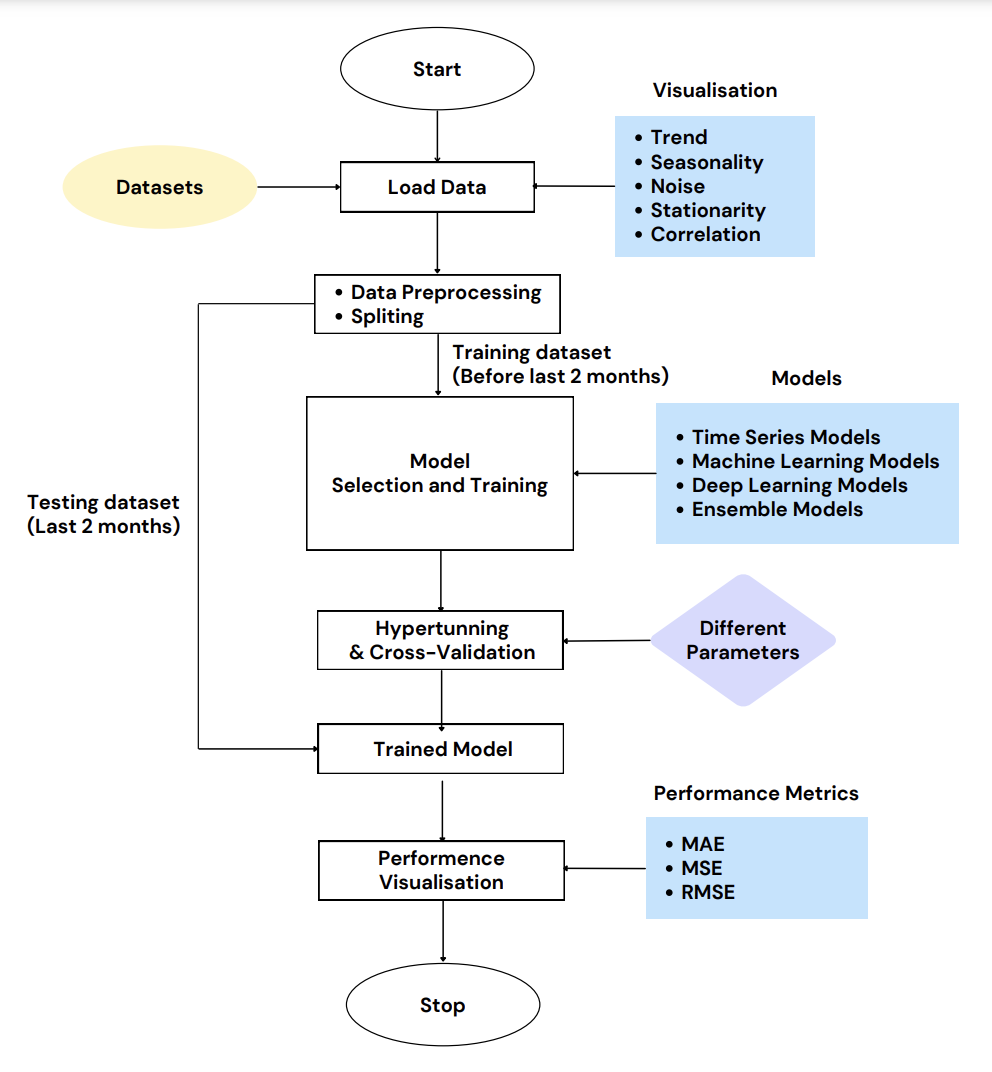

In [ ]:
import pandas as pd
import numpy as np
import random

# Set the seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load the data
df = pd.read_csv('/content/drive/MyDrive/Time-series Machine Learning/weather.csv')

df.columns = [
    "Date and Time", "Inside Temp 1", "Outside Temp",
    "CPU Temp", "Count", "Inside Temp 2",
    "Air Pressure", "Humidity"
]

df.head()

,Date and Time,Inside Temp 1,Outside Temp,CPU Temp,Count,Inside Temp 2,Air Pressure,Humidity
0,Wed 17 Nov 2021 03:21:02 PM GMT,24.2,9.8,36.318,1,26.22,1006.76,31.03
1,Wed 17 Nov 2021 03:22:03 PM GMT,24.2,9.8,36.856,1,26.24,1006.80,30.98
2,Wed 17 Nov 2021 03:23:05 PM GMT,24.2,9.8,40.840,1,26.28,1006.84,30.91
3,Wed 17 Nov 2021 03:24:02 PM GMT,24.2,9.8,36.856,1,26.47,1006.86,30.77
4,Wed 17 Nov 2021 03:25:03 PM GMT,24.2,9.8,36.856,1,26.59,1006.90,30.57


## **Data Preprocessing**

The preprocessing stage began with a thorough examination of the data. Each feature was scrutinised for patterns, anomalies, and data types. Timestamps were standardised to account for daylight saving changes, ensuring consistency. I resampled the data to one-minute intervals to standardise the series, allowing for a uniform temporal structure necessary for time-series analysis. The data was then split into training and test sets, with the last two months reserved for testing to prevent leakage and ensure a fair assessment of the models' predictive capabilities.

Decomposition was the next critical step, helping to disentangle the data into its constituent parts: trend, seasonality, and residuals. The decomposition plots revealed an observable trend and non-seasonal patterns within the 'Outside Temp' readings, both of which could significantly influence the models' performance. The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots are conducted in order to determine the autoregressive (AR) and moving average (MA) components for the ARIMA model, as they could identify the lag values where the correlations are significant (Shambulingappa, 2020).

In [ ]:
# Adjust the time for BST (British Summer Time), which is GMT+1
def adjust_bst(time_str):
    if isinstance(time_str, float):
        return time_str
    ## If the timezone is BST, add one hour
    if 'BST' in time_str:
        return pd.to_datetime(time_str[:-4], format='%a %d %b %Y %I:%M:%S %p') + pd.Timedelta(hours=1)
    else:
        return pd.to_datetime(time_str[:-4], format='%a %d %b %Y %I:%M:%S %p')

df['Date and Time'] = df['Date and Time'].apply(adjust_bst)

df.head()

,Date and Time,Inside Temp 1,Outside Temp,CPU Temp,Count,Inside Temp 2,Air Pressure,Humidity
0,2021-11-17 15:21:02,24.2,9.8,36.318,1,26.22,1006.76,31.03
1,2021-11-17 15:22:03,24.2,9.8,36.856,1,26.24,1006.80,30.98
2,2021-11-17 15:23:05,24.2,9.8,40.840,1,26.28,1006.84,30.91
3,2021-11-17 15:24:02,24.2,9.8,36.856,1,26.47,1006.86,30.77
4,2021-11-17 15:25:03,24.2,9.8,36.856,1,26.59,1006.90,30.57


In [ ]:
# Initial Data Preparation
## Set 'Date and Time' as the DataFrame index
df.set_index('Date and Time', inplace=True)

## Ensure data is resampled at a one-minute interval
data = df.resample('1T').mean().interpolate()

In [ ]:
# Prediction data Preparation
feature = 'Outside Temp'
prediction_horizons = [5, 10, 15, 30, 60, 120, 360, 720]  ### minutes

## Splitting the dataset
train_data = data[data.index < '2022-11-01']
test_data = data[data.index >= '2022-11-01']

## Function for prepare data for each model
def prepare_model_data(df, feature, horizon):
    df_prepared = df.copy()
    df_prepared['Target'] = df_prepared[feature].shift(-horizon)
    df_prepared = df_prepared.iloc[:-horizon, :]

    if 'Date and Time' in df_prepared.columns:
        df_prepared = df_prepared.drop(['Date and Time'], axis=1)

    if 'Count' in df_prepared.columns:
        df_prepared = df_prepared.drop(['Count'], axis=1)

    X = df_prepared.drop(['Target'], axis=1)
    y = df_prepared['Target']
    return X, y

from sklearn.metrics import mean_absolute_error, mean_squared_error

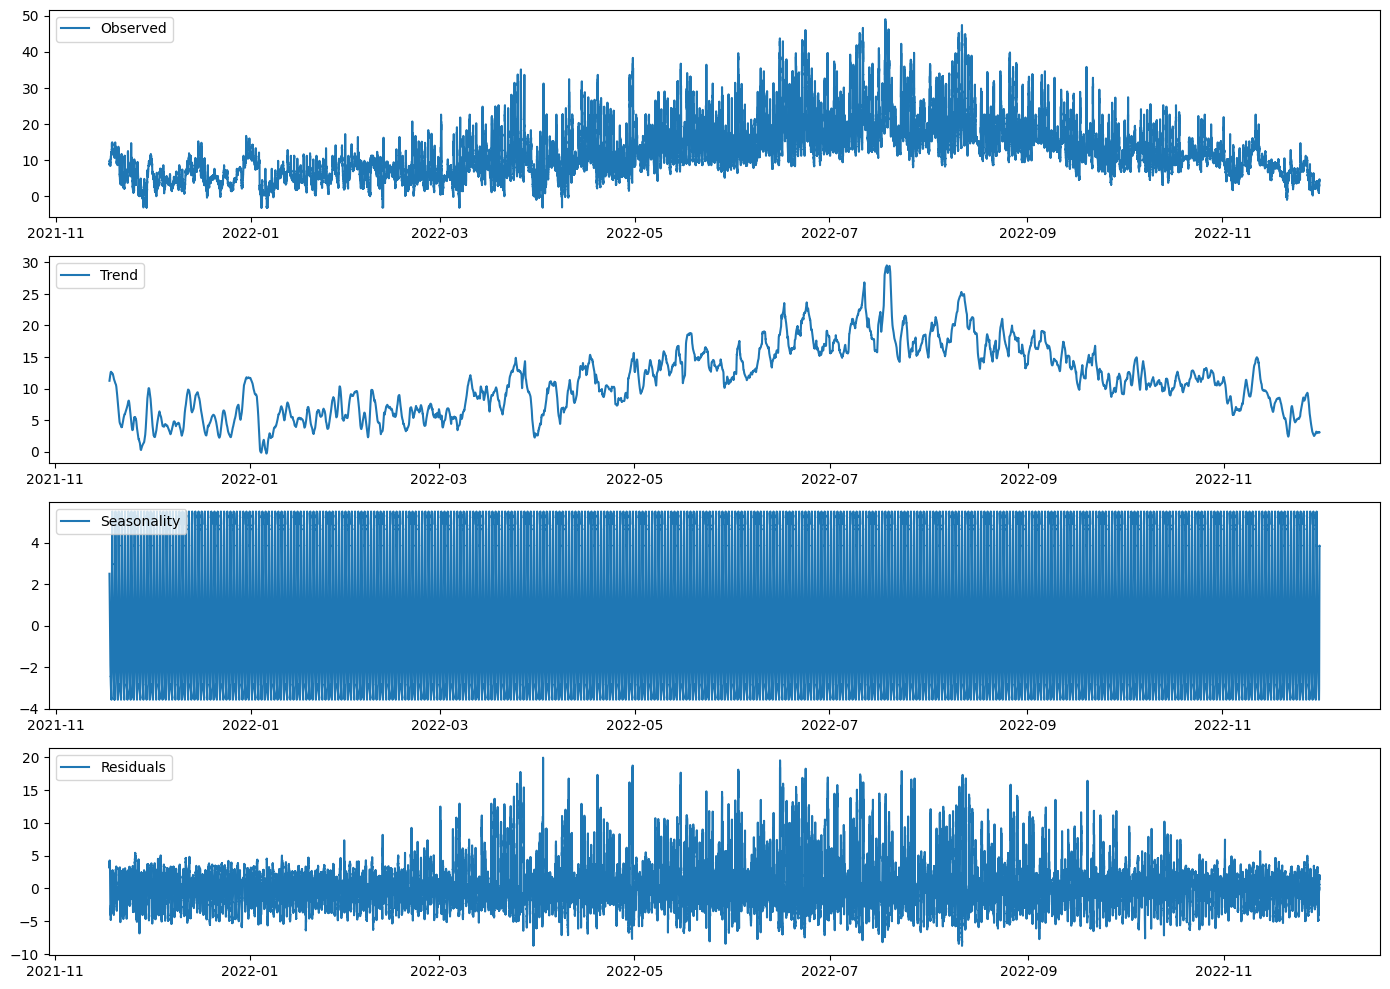

In [ ]:
# Decompose the 'Outside Temp' series
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

period = 1440  # number of minutes in one day
decomposition_data = seasonal_decompose(data['Outside Temp'].dropna(), model='additive', period=period)

## Plot the decomposed components of the series
plt.figure(figsize=(14, 10))

## Plot the observed data
plt.subplot(411)
plt.plot(decomposition_data.observed, label='Observed')
plt.legend(loc='upper left')

## Plot the trend component
plt.subplot(412)
plt.plot(decomposition_data.trend, label='Trend')
plt.legend(loc='upper left')

## Plot the seasonal component
plt.subplot(413)
plt.plot(decomposition_data.seasonal, label='Seasonality')
plt.legend(loc='upper left')

## Plot the residual component
plt.subplot(414)
plt.plot(decomposition_data.resid, label='Residuals')
plt.legend(loc='upper left')

## Adjust layout to prevent overlap
plt.tight_layout()

## Show the plots
plt.show()

In [ ]:
# ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Outside Temp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

ADF Statistic: -20.203686
p-value: 0.000000
Series is stationary


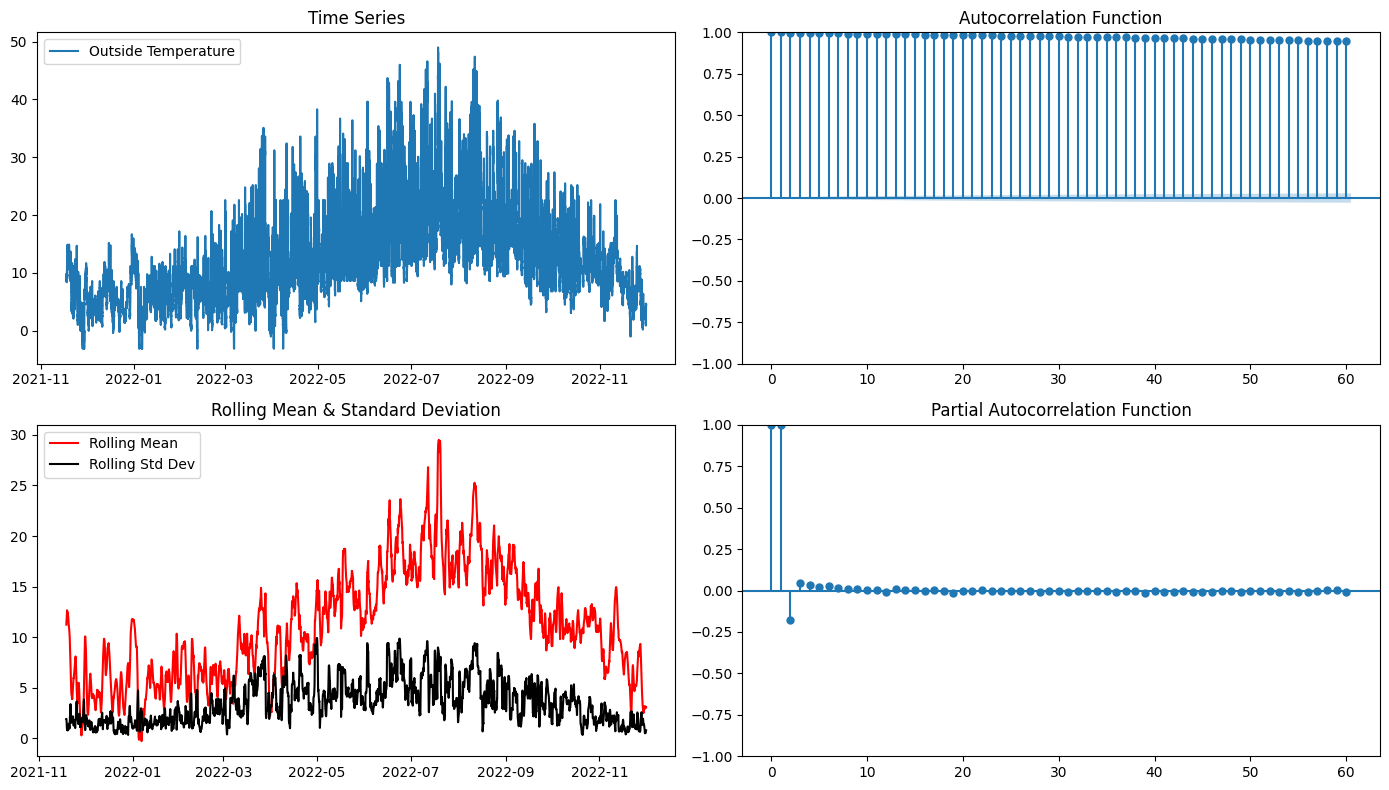

In [ ]:
# Time Series Data Exploration
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 8), dpi=100)

## Time series plot
plt.subplot(221)
plt.plot(data['Outside Temp'], label='Outside Temperature')
plt.title('Time Series')
plt.legend(loc='upper left')

## Rolling statistics with 1440 minutes (1 day)
rolling_mean = data['Outside Temp'].rolling(window=1440).mean()
rolling_std = data['Outside Temp'].rolling(window=1440).std()

plt.subplot(223)
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='black')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='upper left')

## Autocorrelation function (ACF) plot
plt.subplot(222)
plot_acf(data['Outside Temp'], ax=plt.gca(), lags=60)
plt.title('Autocorrelation Function')

## Partial Autocorrelation function (PACF) plot
plt.subplot(224)
plot_pacf(data['Outside Temp'], ax=plt.gca(), lags=60)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

## **Time Series Models**

**ARIMA model**'s parameters (p,d,q) were carefully chosen based on the ACF and PACF plots. The ACF showed a gradual decline, indicating an AR process. Without a clear cutoff, it is harder to choose q, I then applied the common approach is to start with q=1. On the other hand, the PACF exhibited a sharp cut-off after the second lag, suggesting a MA process, as the PACF at lag 2 is still significant, p=2 is reasonable. The differencing term (d) was derived from the Augmented Dickey-Fuller test, which confirmed the series' stationarity, rendering additional differencing unnecessary, thus, d=0 (Chen et al., 2017). Given the absence of clear seasonal patterns after decomposition, an ARIMA model was deemed appropriate (Yao and Zhang, 2017).

**HWES (Holt-Winters Exponential Smoothing)** was used for capturing level, trend, and seasonality through exponential smoothing, making it a viable alternative to ARIMA for time-series forecasting. It uses much less hypertunning as compared to models like ARIMA, but the forecasting is robust despite its simplicity (Garg et al., 2022).

Both models were evaluated for their forecasting accuracy at various time horizons, thus providing a comprehensive understanding of their short-term and long-term predictive capabilities.

In [ ]:
# ARIMA Model - Training
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = train_data.asfreq('T')
test_data = test_data.asfreq('T')

arima_model = SARIMAX(train_data['Outside Temp'],
                       order=(2, 0, 0),  ### Non-seasonal ARIMA order
                       seasonal_order=(0, 0, 0, 0)).fit(disp=False)  ### No seasonal component


In [ ]:
# ARIMA Model - Prediction and Evalualation
arima_results = {}
for horizon in prediction_horizons:
    ## Forecast for the given horizon
    forecasted_values = arima_model.get_forecast(steps=horizon)
    y_pred = forecasted_values.predicted_mean

    ## Actual values for comparison
    y_test = test_data['Outside Temp'].iloc[:horizon]

    ## Compute metrics for the current horizon
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    arima_results[horizon] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

## Calculate average results across all horizons
average_arima_results = {k: np.mean([v[k] for v in arima_results.values()]) for k in arima_results[next(iter(prediction_horizons))]}
print("Average ARIMA Model Results:", average_arima_results)

Average ARIMA Model Results: {'MAE': 0.6160838612002696, 'MSE': 2.3413618362104223, 'RMSE': 0.8185389025152526}


In [ ]:
# HWES Model - Training
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hwes_results = {}
hwes_model = ExponentialSmoothing(train_data['Outside Temp'],
                                  trend='add',
                                  seasonal=None).fit()


In [ ]:
# HWES Model - Prediction and Evalualation
hwes_results = {}
for horizon in prediction_horizons:
    ## Forecast for the given horizon
    y_pred = hwes_model.forecast(steps=horizon)

    ## Actual values for comparison
    y_test = test_data['Outside Temp'].iloc[:horizon]

    ## Compute metrics for the current horizon
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    hwes_results[horizon] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

## Calculate average results across all horizons
average_hwes_results = {k: np.mean([v[k] for v in hwes_results.values()]) for k in hwes_results[next(iter(prediction_horizons))]}
print("Average HWES Model Results:", average_hwes_results)

Average HWES Model Results: {'MAE': 0.3860524913166268, 'MSE': 1.3902573368125415, 'RMSE': 0.5992611739330449}


## **Machine Learning Models**

**Lasso regression:** Lasso's ability to perform feature selection inherently by penalizing the absolute size of the regression coefficients is advantageous when dealing with datasets that may contain irrelevant features. Bayesian Ridge followed, introducing a probabilistic approach to regression, which, through its incorporation of the regularization parameter in Bayesian context, offers a more nuanced understanding of the data.

**Bayesian Ridge Regression:** The main idea behind ridge regression is to find a new line that does not fit the training data. It extends the capabilities of linear regression by incorporating Bayesian inference, providing a probabilistic approach to regression that can account for uncertainty in the model parameters.

**XGBoost:** It is a natural choice due to its reputation for high performance in various prediction tasks. As a gradient boosting method, it builds an ensemble of trees sequentially, with each new tree attempting to correct the errors of the previous ensemble. Its strength lies in its flexibility and ability to model complex non-linear relationships (Kumar et al., 2020).

**Random Forest:** It adds a level of robustness to the modeling effort. As an ensemble method itself, it builds multiple decision trees and merges their results to improve the overall prediction. This method is known for its high accuracy, ability to handle a large number of features, and inherent feature selection capabilities (Chen et al., 2005).

**Support Vector Machine (SVM)**: Known for its effectiveness in high-dimensional spaces, the SVM model, particularly with a linear kernel, was considered to capture the linear dependencies within the dataset. While SVMs are computationally intensive and challenging to fine-tune, they provide a robust alternative to traditional regression methods, especially when dealing with complex datasets.

Noting that due to computational constraints, the full optimization of the SVM model through hyperparameter tuning and cross-validation was not feasible. Nonetheless, the process of setting up, initial training, hypertuning, and evaluating an SVM is still documented in this report. Although final results could not be obtained, the detailed steps are presented to showcase the process, Details explained in the further specifc SVM part.



In [ ]:
# Function for Evaluating Each Model
from sklearn.model_selection import GridSearchCV

def compute_metrics(model, horizons, train_data, test_data, feature):
    metrics = {'MAE': 0, 'MSE': 0, 'RMSE': 0}
    for horizon in horizons:
        X_train, y_train = prepare_model_data(train_data, feature, horizon)
        X_test, y_test = prepare_model_data(test_data, feature, horizon)

        y_pred = model.predict(X_test)
        metrics['MAE'] += mean_absolute_error(y_test, y_pred)
        metrics['MSE'] += mean_squared_error(y_test, y_pred)
        metrics['RMSE'] += np.sqrt(mean_squared_error(y_test, y_pred))
    return {k: v / len(horizons) for k, v in metrics.items()}

def evaluate_model(model, train_data, test_data, feature, prediction_horizons):
    results = {}
    for horizon in prediction_horizons:
        X_test, y_test = prepare_model_data(test_data, feature, horizon)
        y_pred = model.predict(train_data.iloc[-len(y_test):])
        results[horizon] = compute_metrics(model, [horizon], train_data, test_data, feature)

    average_results = {k: np.mean([v[k] for v in results.values()]) for k in results[next(iter(prediction_horizons))]}
    return average_results

## **Model Development and Validation Strategy**

In the quest to predict "Outside Temperature" accurately, I employed a systematic approach. I trained each model on the training dataset and evaluated its performance on the test dataset using Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) as metrics. These metrics were chosen for their ability to quantify prediction accuracy in different ways:

**Mean absolute error (MAE)** is the absolute difference between the model predictions and the actual values. It is to calculate the difference between true values and predicted values, calculate the average of this point after summing it. If MAE=0, it means the model is perfect for the prediction. The error increases in proportional order (Chen et al., 2017).

**Mean square error (MSE)** is similar to MAE but instead of obtaining absolute value squaring of the value takes place.

**Root mean square error (RMSE)** is simply the square root of the MSE value. The main problem with MSE is that the units are very different from the actual data points as the data is squared, which makes it difficult to compare (Chen et al., 2005).

Each model went through a rigorous experiment and interpretation process. Post-training with the default parameters of each model, I utilized grid search for hyperparameter tuning, employing cross-validation to ensure that the model's performance was consistent across different subsets of the training data. By tuning hyperparameters, I sought to refine each model's ability to generalize to new, unseen data while avoiding overfitting.

The evaluation process revealed insightful performance differences. For instance, while the Lasso model provided a fairly decent baseline performance, tuning its alpha parameter led to slight improvements, as evidenced by the decrease in MSE. Bayesian Ridge regression yielded similar results, reinforcing the potential of linear models for this forecasting task.



In [ ]:
# Lasso Model
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.01)

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
lasso_model.fit(X_train, y_train)

# Evaluate Lasso Model
average_lasso_results = evaluate_model(lasso_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average Lasso Model Results:", average_lasso_results)


Average Lasso Model Results: {'MAE': 3.382896371118015, 'MSE': 16.011080392384944, 'RMSE': 3.99812130080917}


In [ ]:
# Lasso Model Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

## Grid search with cross-validation
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

## Best hyperparameters
print("Best Lasso hyperparameters:", lasso_grid.best_params_)


Best Lasso hyperparameters: {'alpha': 0.001}


In [ ]:
# Tuned Lasso Model
tuned_lasso_model = Lasso(alpha=0.001)

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
tuned_lasso_model.fit(X_train, y_train)

# Evaluate Tuned Lasso Model
average_tuned_lasso_results = evaluate_model(tuned_lasso_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average Tuned Lasso Model Results:", average_tuned_lasso_results)


Average Tuned Lasso Model Results: {'MAE': 3.369047529013966, 'MSE': 15.903047611934094, 'RMSE': 3.9845564051609594}


In [ ]:
# Bayesian Ridge Regression Model
from sklearn.linear_model import BayesianRidge

bayesian_ridge_model = BayesianRidge()

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
bayesian_ridge_model.fit(X_train, y_train)

# Evaluate Bayesian Ridge Regression Model
average_bayesian_ridge_results = evaluate_model(bayesian_ridge_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average Bayesian Ridge Model Results:", average_bayesian_ridge_results)

Average Bayesian Ridge Model Results: {'MAE': 3.3676353601390736, 'MSE': 15.892086149044303, 'RMSE': 3.983177446152374}


In [ ]:
# Bayesian Ridge Regression Model Tuning
bayesian_ridge_params = {
    'alpha_1': [1e-7, 1e-6, 1e-5],
    'alpha_2': [1e-7, 1e-6, 1e-5],
    'lambda_1': [1e-7, 1e-6, 1e-5],
    'lambda_2': [1e-7, 1e-6, 1e-5]
}

## Grid search with cross-validation
bayesian_ridge_grid = GridSearchCV(BayesianRidge(), bayesian_ridge_params, cv=5, scoring='neg_mean_squared_error')
bayesian_ridge_grid.fit(X_train, y_train)

## Best hyperparameters
print("Best Bayesian Ridge hyperparameters:", bayesian_ridge_grid.best_params_)


Best Bayesian Ridge hyperparameters: {'alpha_1': 1e-05, 'alpha_2': 1e-05, 'lambda_1': 1e-07, 'lambda_2': 1e-05}


In [ ]:
# Tuned Bayesian Ridge Regression Model

best_params = {'alpha_1': 1e-05, 'alpha_2': 1e-05, 'lambda_1': 1e-07, 'lambda_2': 1e-05}
tuned_bayesian_ridge_model = BayesianRidge(**best_params)

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
tuned_bayesian_ridge_model.fit(X_train, y_train)

# Evaluate Tuned Bayesian Ridge Regression Model
average_tuned_bayesian_ridge_results = evaluate_model(tuned_bayesian_ridge_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average Tuned Bayesian Ridge Regression Model Results:", average_tuned_bayesian_ridge_results)

Average Tuned Bayesian Ridge Regression Model Results: {'MAE': 3.3676353598437356, 'MSE': 15.892086146630257, 'RMSE': 3.9831774458485496}


In [ ]:
# XGBoost Model
import xgboost as xgb

xgboost_model = xgb.XGBRegressor(objective ='reg:squarederror')

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
xgboost_model.fit(X_train, y_train)

# Evaluate XGBoost Model
average_xgboost_results = evaluate_model(xgboost_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average XGBoost Model Results:", average_xgboost_results)


Average XGBoost Model Results: {'MAE': 4.415789455940208, 'MSE': 28.15189968628357, 'RMSE': 5.305800588283868}


In [ ]:
# XGBoost Model Hyperparameter Tuning
xgboost_params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

## Grid search with cross-validation
xgboost_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), xgboost_params, cv=5, scoring='neg_mean_squared_error')
xgboost_grid.fit(X_train, y_train)

## Best hyperparameters
print("Best XGBoost hyperparameters:", xgboost_grid.best_params_)

Best XGBoost hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [ ]:
# Tuned XGBoost Model

best_xgboost_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
tuned_xgboost_model = xgb.XGBRegressor(**best_xgboost_params, objective='reg:squarederror')

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
tuned_xgboost_model.fit(X_train, y_train)

# Evaluate Tuned XGBoost Model
average_tuned_xgboost_results = evaluate_model(tuned_xgboost_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average Tuned XGBoost Model Results:", average_tuned_xgboost_results)


Average Tuned XGBoost Model Results: {'MAE': 4.699976100482745, 'MSE': 30.902078362426934, 'RMSE': 5.558941801707562}


In [ ]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
rf_model.fit(X_train, y_train)

# Evaluate Random Forest Model
average_rf_results = evaluate_model(rf_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average Random Forest Model Results:", average_rf_results)

Average Random Forest Model Results: {'MAE': 5.101295088256112, 'MSE': 38.0482975534872, 'RMSE': 6.168232433598449}


In [ ]:
# Random Forest Model Hyperparameter Tuning
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None]
}

## Grid search with cross-validation
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

## Best hyperparameters
print("Best Random Forest hyperparameters:", rf_grid.best_params_)

Best Random Forest hyperparameters: {'max_depth': 10, 'n_estimators': 50}


In [ ]:
# Tuned Random Forest Model
tuned_rf_model = RandomForestRegressor(n_estimators=100, max_depth=10)

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
tuned_rf_model.fit(X_train, y_train)

# Evaluate Tuned Random Forest Model
average_tuned_rf_results = evaluate_model(tuned_rf_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average Tuned Random Forest Model Results:", average_tuned_rf_results)

Average Tuned Random Forest Model Results: {'MAE': 4.903192712143063, 'MSE': 30.513296306696947, 'RMSE': 5.5236997282453455}


**Notes on SVM Model**

In the pursuit of a comprehensive analysis, Support Vector Machines (SVM) was also considered for modeling the dataset, as SVM is known for its effectiveness in high-dimensional spaces and are particularly adept at performing regression tasks. The initial model was configured with a linear kernel to understand the linear relationships within the data. Given the computational intensity of SVMs, particularly with large datasets, a complete hyperparameter tuning and cross-validation were initiated to optimize the model's performance.

However, due to the computational limitations encountered, the full spectrum of the tuning process could not be realized within the scope of this project. Despite this, the entire training setup and tuning process with evaluation have been included in the report as an illustrative example of how SVMs can be applied and potentially optimized for this time-series forecasting task.

In [ ]:
# SVM Linear Model
from sklearn.svm import SVR

svm_linear_results = {}
svm_linear_model = SVR(kernel='linear')

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
svm_linear_model.fit(X_train, y_train)

# Evaluate SVM Linear Model
average_svm_linear_results = evaluate_model(svm_linear_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average SVM Linear Model Results:", average_svm_linear_results)

In [ ]:
# SVM Linear Model Hyperparameter Tuning
svm_linear_params = {'C': [0.1, 1, 10]}

## Grid search with cross-validation
svm_linear_grid = GridSearchCV(SVR(kernel='linear'), svm_linear_params, cv=5, scoring='neg_mean_squared_error')
svm_linear_grid.fit(X_train, y_train)

## Best hyperparameters
print("Best SVM Linear hyperparameters:", svm_linear_grid.best_params_)

In [ ]:
# Tuned SVM Linear Model
from sklearn.svm import SVR
from statistics import mean

tuned_svm_linear_model = SVR(kernel='linear')

tuned_X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
tuned_svm_linear_model.fit(X_train, y_train)

# Evaluate tuned SVM Linear Model
average_tuned_svm_linear_results = evaluate_model(tuned_svm_linear_model, X_train, test_data, 'Outside Temp', prediction_horizons)
print("Average SVM Linear Model Results:", average_tuned_svm_linear_results)

## **Deep Learning Approach: LSTM**

Transitioning to the deep learning realm, the Long Short-Term Memory (LSTM) model stands out for its proficiency in processing sequential data. LSTM's ability to remember information over long periods is pivotal for time-series forecasting, which is inherently sequential. This capability is crucial in capturing the patterns in temperature changes over time, which is crucial to time-series forecasting (Chakraborty et al., 2021).

**Data Preparation for LSTM**

In preparing data for LSTM, I transformed the continuous temperature readings into structured sequences, essential for the model to understand and predict temporal patterns. By creating input sequences of fixed lengths with the subsequent temperature reading as the target, I enabled the LSTM to learn the progression of temperatures over time. This process aligns the dataset with the inherent capabilities of LSTMs, which are adept at capturing and forecasting based on sequential data.

**LSTM Parameter Setting**

The architecture of the LSTM, including the choice of hidden layer size, number of layers, learning rate, epochs, and dropout, plays a crucial role in its forecasting ability. These parameters were meticulously chosen to ensure a balance between the model's complexity and computational efficiency. For instance, a hidden layer size of 50 units and two layers were selected to capture the data's nuances without overfitting. The learning rate and epochs were set to allow steady learning and adequate iterations for the model to grasp the temperature patterns. Additionally, the inclusion of dropout as a regularisation technique helps prevent overfitting, ensuring that the model remains robust and performs well on unseen data.

**Training and Evaluation of the LSTM Model**

Training the LSTM model is an iterative process where the model learns to minimize the difference between its predictions and the actual temperatures. Over multiple epochs, the model's weights are adjusted to improve its forecasting accuracy. This iterative refinement is essential to hone the LSTM's predictive capabilities, enabling it to generalise well to the test data and capture the underlying trends and seasonality in temperature changes (Sagheer and Kotb, 2019).

The performance of the LSTM model was evaluated using the same metrics as the previous models to ensure consistency in comparison. The results were promising without conducting any hypertuning, showcasing the LSTM's great potential in time-series forecasting. This segment of the report not only demonstrates the LSTM's practicality for the task but also reinforces the importance of employing a deep learning model when dealing with complex sequential data like weather time-series.

In [ ]:
# LSTM Model - Data Preparation
import torch
import torch.nn as nn

## Set a seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

train_data_np = train_data['Outside Temp'].values.astype(np.float32)
test_data_np = test_data['Outside Temp'].values.astype(np.float32)

## Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
train_sequences, train_labels = create_sequences(train_data_np, seq_length)
test_sequences, test_labels = create_sequences(test_data_np, seq_length)

## Convert to PyTorch tensors
train_sequences = torch.tensor(train_sequences).view(-1, seq_length, 1)
train_labels = torch.tensor(train_labels).view(-1, 1)
test_sequences = torch.tensor(test_sequences).view(-1, seq_length, 1)
test_labels = torch.tensor(test_labels).view(-1, 1)

In [ ]:
# LSTM Model - Parameter Setting
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

## Initialise the model
lstm_model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
batch_size = 64

In [ ]:
# LSTM Model - Training with Batches
for epoch in range(100):
    lstm_model.train()
    for i in range(0, len(train_sequences), batch_size):
        batch_seq = train_sequences[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]

        optimizer.zero_grad()
        output = lstm_model(batch_seq)
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0:  ## print every 20 epochs
        print(f'Epoch {epoch} loss: {loss.item()}')

Epoch 0 loss: 0.020759044215083122
Epoch 20 loss: 0.014599500223994255
Epoch 40 loss: 0.015560355968773365
Epoch 60 loss: 0.00858311541378498
Epoch 80 loss: 0.006897776387631893


In [ ]:
# LSTM Model - Evaluation
lstm_model.eval()
predictions = lstm_model(test_sequences)
test_loss = criterion(predictions, test_labels).item()
print(f'Test Loss: {test_loss}')

predictions_np = predictions.detach().numpy()
test_labels_np = test_labels.numpy()

lstm_model_results = {}
def evaluate_model(model, train_sequences, test_labels, horizons):
    model.eval()
    for horizon in horizons:
        y_true = test_labels_np[-horizon:]
        y_pred = predictions_np[-horizon:]
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        lstm_model_results[horizon] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    return lstm_model_results

# Evaluate LSTM Model
metrics = evaluate_model(lstm_model, train_sequences, test_labels, prediction_horizons)

average_lstm_model_results = {k: np.mean([v[k] for v in lstm_model_results.values()]) for k in lstm_model_results[next(iter(prediction_horizons))]}
print("Average LSTM model Results:", average_lstm_model_results)

Test Loss: 0.020289799198508263
Average LSTM model Results: {'MAE': 0.098161936, 'MSE': 0.018019343, 'RMSE': 0.11700322}


## **Ensemble Modeling Techniques**

After each machine-learning model fitted and tuned, I proceeded with Ensemble Modeling Techniques. The rationale is to leverage the strengths and mitigate the weaknesses of various predictive models. By combining the predictions of multiple models, I aim to improve the accuracy and robustness of the forecasts. This method may be particularly effective in time-series forecasting, where different models may capture different aspects of the data.

**The Average Ensemble** combined predictions by simple averaging, intending to smooth out individual model variances. This technique is straightforward yet powerful when the models are diverse. By averaging the predictions of all my diverse machine-learning models, I aimed to minimize any potential bias or variance errors that might be present in individual models. This method proved to be beneficial, yielding a notably consistent performance across various metrics when compared to individual model outputs.

**The Weighted Average Ensemble** takes into account the performance of each individual model by assigning weights inversely proportional to their Mean Squared Error (MSE). Models that performed better (lower MSE) have a more significant impact on the final prediction. Comparing to the Average Ensemble, it did not yield the expected improvement. One possible explanation for this could be the overfitting of weights to the development dataset, resulting in poorer generalization on the test set. Another factor could be the interplay of model errors. If these errors are correlated, even weighted averaging might not efficiently address them. These outcomes illustrate a crucial lesson in ensemble modeling: more complexity does not always translate to better performance.

**The Stacking Ensemble** is a even more complex ensemble technique that uses a new model, known as the meta-learner, to learn the optimal combination of the predictions from the base models (Chen et al., 2017). In this case, the base models were the same as those in the Weighted Average Ensemble, and a Linear Regression model was used as the meta-learner. The Stacking Ensemble is designed to capture different aspects of the prediction task that may be missed by individual models. Notably, the Stacking Ensemble excelled by adapting and learning the best ways to integrate different models' strengths, leading to a performance that was not only improved over the Weighted Average Ensemble but also indicative of the potential within meta-learning techniques.

Upon analyzing the ensemble models' performance, the Weighted Average Ensemble, by assigning weights based on MSE, did not managed to improve upon the simple average approach. However, it was the Stacking Ensemble that truly shone by effectively learning how to best combine the predictions of the base learners, thereby providing a more robust and accurate forecast.

In [ ]:
# Voting Ensemble - Average(LG+BR+XB+RF)
avg_ensemble_results = {}

for horizon in prediction_horizons:
    _, y_test = prepare_model_data(test_data, 'Outside Temp', horizon)

    ## Choose models from diverse algorithms
    y_pred_tuned_lasso = tuned_lasso_model.predict(X_train[-len(y_test):])
    y_pred_tuned_bayesian_ridge = tuned_bayesian_ridge_model.predict(X_train[-len(y_test):])
    y_pred_xgboost = xgboost_model.predict(X_train[-len(y_test):])  # Using original XGBoost model
    y_pred_tuned_rf = tuned_rf_model.predict(X_train[-len(y_test):])

    y_pred_avg_ensemble = (y_pred_tuned_lasso + y_pred_tuned_bayesian_ridge + y_pred_xgboost + y_pred_tuned_rf) / 4

    ## Calculate performence metrics
    mae = mean_absolute_error(y_test, y_pred_avg_ensemble)
    mse = mean_squared_error(y_test, y_pred_avg_ensemble)
    rmse = np.sqrt(mse)

    avg_ensemble_results[horizon] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Evaluate Average Ensemble with Tuned Models
average_avg_ensemble_results = {k: np.mean([v[k] for v in avg_ensemble_results.values()]) for k in avg_ensemble_results[next(iter(prediction_horizons))]}
print("Average Ensemble Results across Horizons:", average_avg_ensemble_results)


Average Ensemble Results across Horizons: {'MAE': 5.497511480381558, 'MSE': 40.204834935149485, 'RMSE': 6.340713922811279}


In [ ]:
# Voting Ensemble - Weighted Average(LG+BR+XB+RF) - Preparation
inverse_mse_lasso = 1 / average_lasso_results['MSE']
inverse_mse_bayesian_ridge = 1 / average_tuned_bayesian_ridge_results['MSE']
inverse_mse_xgboost = 1 / average_xgboost_results['MSE']
inverse_mse_rf = 1 / average_rf_results['MSE']

sum_inverse_mses = inverse_mse_lasso + inverse_mse_bayesian_ridge + inverse_mse_xgboost + inverse_mse_rf

## Calculating weights
weight_lasso = inverse_mse_lasso / sum_inverse_mses
weight_xgboost = inverse_mse_xgboost / sum_inverse_mses
weight_rf = inverse_mse_rf / sum_inverse_mses
weight_bayesian_ridge = inverse_mse_bayesian_ridge / sum_inverse_mses

print("Weights - Lasso: {:.2f}, XGBoost: {:.2f}, Random Forest: {:.2f}, Bayesian Ridge: {:.2f}".format(
    weight_lasso, weight_bayesian_ridge, weight_xgboost, weight_rf))


Weights - Lasso: 0.33, XGBoost: 0.34, Random Forest: 0.19, Bayesian Ridge: 0.14


In [ ]:
# Voting Ensemble - Weighted Average(LG+BR+XB+RF) - Execution
weights = {'tuned_lasso': weight_lasso, 'tuned_bayesian_ridge': weight_bayesian_ridge, 'xgboost': weight_xgboost, 'tuned_rf': weight_rf}
weighted_ensemble_results = {}

for horizon in prediction_horizons:
    X_, y_test = prepare_model_data(test_data, 'Outside Temp', horizon)

    ## Choose models from diverse algorithms
    y_pred_weighted_avg = (weights['tuned_lasso'] * tuned_lasso_model.predict(X_train[-len(y_test):]) +
                           weights['tuned_bayesian_ridge'] * tuned_bayesian_ridge_model.predict(X_train[-len(y_test):]) +
                           weights['xgboost'] * xgboost_model.predict(X_train[-len(y_test):]) +
                           weights['tuned_rf'] * tuned_rf_model.predict(X_train[-len(y_test):]))

    mae = mean_absolute_error(y_test, y_pred_weighted_avg)
    mse = mean_squared_error(y_test, y_pred_weighted_avg)
    rmse = np.sqrt(mse)

    weighted_ensemble_results[horizon] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Evaluate Weighted Average Ensemble with Tuned Models
weighted_average_ensemble_results = {k: np.mean([v[k] for v in weighted_ensemble_results.values()]) for k in weighted_ensemble_results[next(iter(prediction_horizons))]}
print("Weighted Average Ensemble Results:", weighted_average_ensemble_results)


Weighted Average Average Ensemble Results: {'MAE': 5.755746356366327, 'MSE': 43.8275213494243, 'RMSE': 6.620220655717813}


In [ ]:
# Stacking Ensemble(LG+BR+XB+RF)
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

stacking_ensemble_results = {}

## Choose models from diverse algorithms
estimators = [
    ('tuned_lasso', tuned_lasso_model),
    ('tuned_bayesian_ridge', tuned_bayesian_ridge_model),
    ('xgboost', xgboost_model),  ### Original model since it performs better
    ('tuned_rf', tuned_rf_model)
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

X_train, y_train = prepare_model_data(train_data, 'Outside Temp', max(prediction_horizons))
stacking_model.fit(X_train, y_train)

for horizon in prediction_horizons:
    X_, y_test = prepare_model_data(test_data, 'Outside Temp', horizon)
    y_pred_stacking = stacking_model.predict(X_train[-len(y_test):])

    mae = mean_absolute_error(y_test, y_pred_stacking)
    mse = mean_squared_error(y_test, y_pred_stacking)
    rmse = np.sqrt(mse)

    stacking_ensemble_results[horizon] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Evaluate Stacking Ensemble(LG+XB+RF)
average_stacking_ensemble_results = {k: np.mean([v[k] for v in stacking_ensemble_results.values()]) for k in stacking_ensemble_results[next(iter(prediction_horizons))]}
print("Average Stacking Ensemble Results:", average_stacking_ensemble_results)

Average Stacking Ensemble Results: {'MAE': 4.721044878069339, 'MSE': 31.02950417947313, 'RMSE': 5.570404792547895}


## **Comparative Analysis of Model Performance**

The comprehensive evaluation of the forecasting models revealed intriguing insights into their performance on the weather time-series data. The following comparative table and subsequent visualizations unveiled distinct differences in model efficacy, with certain categories of models emerging as more adept at harnessing the underlying patterns of the dataset.

** **
**Linear and Tree-Based Models: A Middle Ground**

Linear models, including Lasso and Bayesian Ridge, achieved moderate success, reflecting the intrinsic value of simplicity and explainability in model selection. Although these models did not attain the highest precision, their performance improved with fine-tuning, highlighting the potential of model calibration.

Tree-based models, including Random Forest and XGBoost, traditionally excel in capturing complex data structures. However, in this case, they encountered relatively higher error rates. This could suggest a misalignment between the models' capacity to manage non-linearity and the dataset's characteristics or perhaps an inclination towards overfitting.

** **
**Specialized Models: The Deep Learning and Time Series**

Shifting to more specialized models, the Time Series category demonstrated superior accuracy, with models like HWES significantly outperforming others. Their lower error metrics in the visual comparison reflect an intrinsic alignment with the temporal data structure, allowing them to capture and forecast based on sequential patterns effectively.


** **
**Ensemble Models: Synergy Over Solo Performance**

The Ensemble models in my analysis combined various forecasting approaches to achieve a synergy that often surpassed individual model performances. The Weighted Average Voting Ensemble, provided a nuanced forecast by emphasizing more accurate models in its aggregation. Despite its sophisticated approach, it did not quite reach the efficacy of the simpler Average Ensemble, suggesting that in some cases, complexity doesn't necessarily yield better results. The Stacking Ensemble, on the other hand, excelled by employing a meta-learner to determine the optimal blend of the base models' predictions. This approach potentially captured more intricate patterns in the data, leading to its superior performance. The comparative success of the Stacking Ensemble might be attributed to its ability to effectively leverage the distinct strengths of each base model, highlighting the power of meta-learning in enhancing predictive accuracy.

** **
**Top-Performing Models: Time Series and LSTM Take the Lead**

Time Series models and LSTM emerged as the top performers, with the latter one setting a new benchmark for the forecasting accuracy in this project. Their exceptional results highlight the importance of leveraging temporal dynamics and long-term dependencies in time-series data, which are critical for producing reliable forecasts.

** **
**The Final Choice: Precision and Depth**

In the final selection, the choice of model hinged on the trade-off between complexity and precision. The LSTM's unparalleled accuracy in predicting future temperatures made it the preferred model for this project, despite its computational intensity. Its ability to model the data's temporal intricacies and predict with high precision made it an optimal choice for the task. This decision was reinforced by the comparative analysis, which consistently placed LSTM at the forefront of performance, making it the final choice for forecasting in this time-series dataset.

In [ ]:
# Evaluation Table of all the models
evaluate_data = {
    'Category': [
        'Time Series Model', 'Time Series Model',
        'Linear Model', 'Linear Model', 'Linear Model', 'Linear Model',
        'Tree Model', 'Tree Model', 'Tree Model', 'Tree Model',
        'Deep Learning Model',
        'Ensemble Model', 'Ensemble Model', 'Ensemble Model'
    ],
    'Model': [
        'ARIMA', 'HWES',
        'Lasso', 'Tuned Lasso', 'Bayesian Ridge', 'Tuned Bayesian Ridge',
        'XGBoost', 'Tuned XGBoost', 'Random Forest', 'Tuned Random Forest',
        'LSTM',
        'Average Ensemble', 'Weighted Avg Ensemble', 'Stacking Ensemble'
    ],
    'MAE': [
        average_arima_results['MAE'], average_hwes_results['MAE'],
        average_lasso_results['MAE'], average_tuned_lasso_results['MAE'], average_bayesian_ridge_results['MAE'], average_tuned_bayesian_ridge_results['MAE'],
        average_xgboost_results['MAE'], average_tuned_xgboost_results['MAE'], average_rf_results['MAE'], average_tuned_rf_results['MAE'],
        average_lstm_model_results['MAE'],
        average_avg_ensemble_results['MAE'], weighted_average_ensemble_results['MAE'], average_stacking_ensemble_results['MAE']
    ],
    'MSE': [
        average_arima_results['MSE'], average_hwes_results['MSE'],
        average_lasso_results['MSE'], average_tuned_lasso_results['MSE'], average_bayesian_ridge_results['MSE'], average_tuned_bayesian_ridge_results['MSE'],
        average_xgboost_results['MSE'], average_tuned_xgboost_results['MSE'], average_rf_results['MSE'], average_tuned_rf_results['MSE'],
        average_lstm_model_results['MSE'],
        average_avg_ensemble_results['MSE'], weighted_average_ensemble_results['MSE'], average_stacking_ensemble_results['MSE']
    ],
    'RMSE': [
        average_arima_results['RMSE'], average_hwes_results['RMSE'],
        average_lasso_results['RMSE'], average_tuned_lasso_results['RMSE'], average_bayesian_ridge_results['RMSE'], average_tuned_bayesian_ridge_results['RMSE'],
        average_xgboost_results['RMSE'], average_tuned_xgboost_results['RMSE'], average_rf_results['RMSE'], average_tuned_rf_results['RMSE'],
        average_lstm_model_results['RMSE'],
        average_avg_ensemble_results['RMSE'], weighted_average_ensemble_results['RMSE'], average_stacking_ensemble_results['RMSE']
    ]
}

comparison_df = pd.DataFrame(evaluate_data)

## Round the numeric columns to 2 decimal places
def format_float(val):
    return '{:.2f}'.format(val).rstrip('0').rstrip('.')

numeric_cols = ['MAE', 'MSE', 'RMSE']
for col in numeric_cols:
    comparison_df[col] = comparison_df[col].apply(format_float)

comparison_df.index = comparison_df.index + 1

## Create a table for comparison
table_df = comparison_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('border', '1px solid grey'), ('text-align', 'center')]}]
).apply(lambda x: ['background: lightgray' if x.name == 'Category' else '' for i in x], axis=1)

table_df


,Category,Model,MAE,MSE,RMSE
1,Time Series Model,ARIMA,0.62,2.34,0.82
2,Time Series Model,HWES,0.39,1.39,0.6
3,Linear Model,Lasso,3.38,16.01,4
4,Linear Model,Tuned Lasso,3.37,15.9,3.98
5,Linear Model,Bayesian Ridge,3.37,15.89,3.98
6,Linear Model,Tuned Bayesian Ridge,3.37,15.89,3.98
7,Tree Model,XGBoost,4.42,28.15,5.31
8,Tree Model,Tuned XGBoost,4.7,30.9,5.56
9,Tree Model,Random Forest,5.1,38.05,6.17
10,Tree Model,Tuned Random Forest,4.9,30.51,5.52


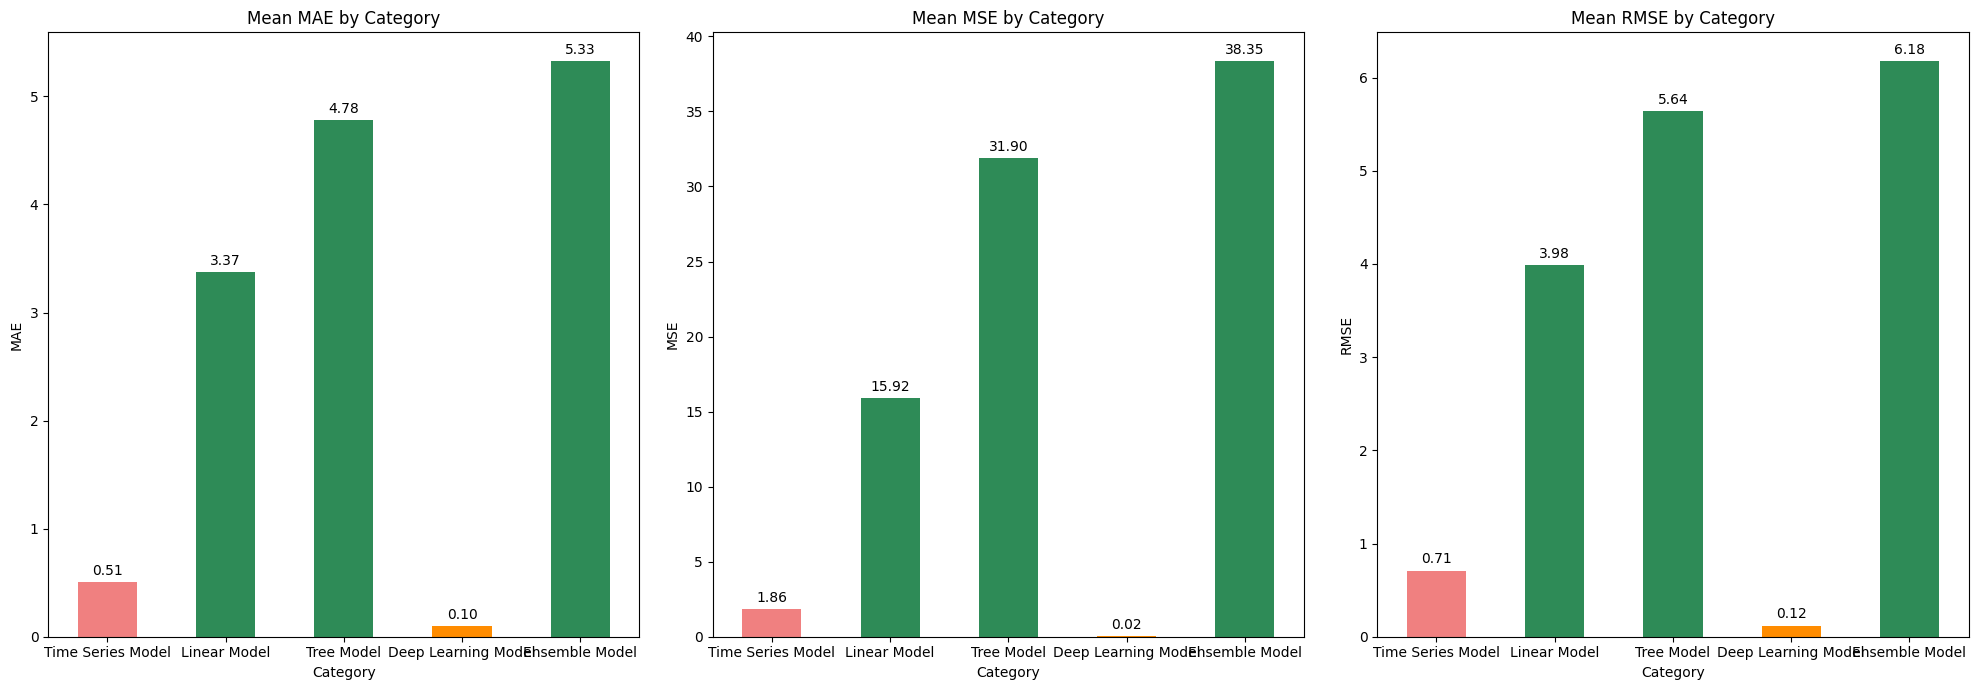

In [ ]:
# Evaluation Plot of all the models - By Category
comparison_df['MAE'] = pd.to_numeric(comparison_df['MAE'], errors='coerce')
comparison_df['MSE'] = pd.to_numeric(comparison_df['MSE'], errors='coerce')
comparison_df['RMSE'] = pd.to_numeric(comparison_df['RMSE'], errors='coerce')

# Group by 'Category' and calculate mean of the performance matrics of each model
category_order = ['Time Series Model', 'Linear Model', 'Tree Model', 'Deep Learning Model', 'Ensemble Model']
comparison_df['Category'] = pd.Categorical(comparison_df['Category'], categories=category_order, ordered=True)

mean_metrics = comparison_df.groupby('Category')[['MAE', 'MSE', 'RMSE']].mean()

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

## Set colors
colors = {
    'Time Series Model': 'lightcoral',
    'Linear Model': 'seagreen',
    'Tree Model': 'seagreen',
    'Deep Learning Model': 'darkorange',  ### The best-performing category
    'Ensemble Model': 'seagreen'
}

## Create the plot
for i, metric in enumerate(['MAE', 'MSE', 'RMSE']):
    ax = axes[i]
    mean_metrics[metric].plot(kind='bar', ax=ax, color=[colors[cat] for cat in mean_metrics.index])

    ### Add data labels
    for bar in ax.patches:
        bar_height = bar.get_height()
        ax.annotate(f'{bar_height:.2f}',
                    (bar.get_x() + bar.get_width() / 2, bar_height),
                    ha='center', va='bottom',
                    xytext=(0, 3), textcoords='offset points')

    ### Add plot titles and labels
    ax.set_title(f'Mean {metric} by Category')
    ax.set_ylabel(metric)
    ax.set_xlabel('Category')
    ax.set_xticklabels(mean_metrics.index, rotation=0)

plt.tight_layout()
plt.show()


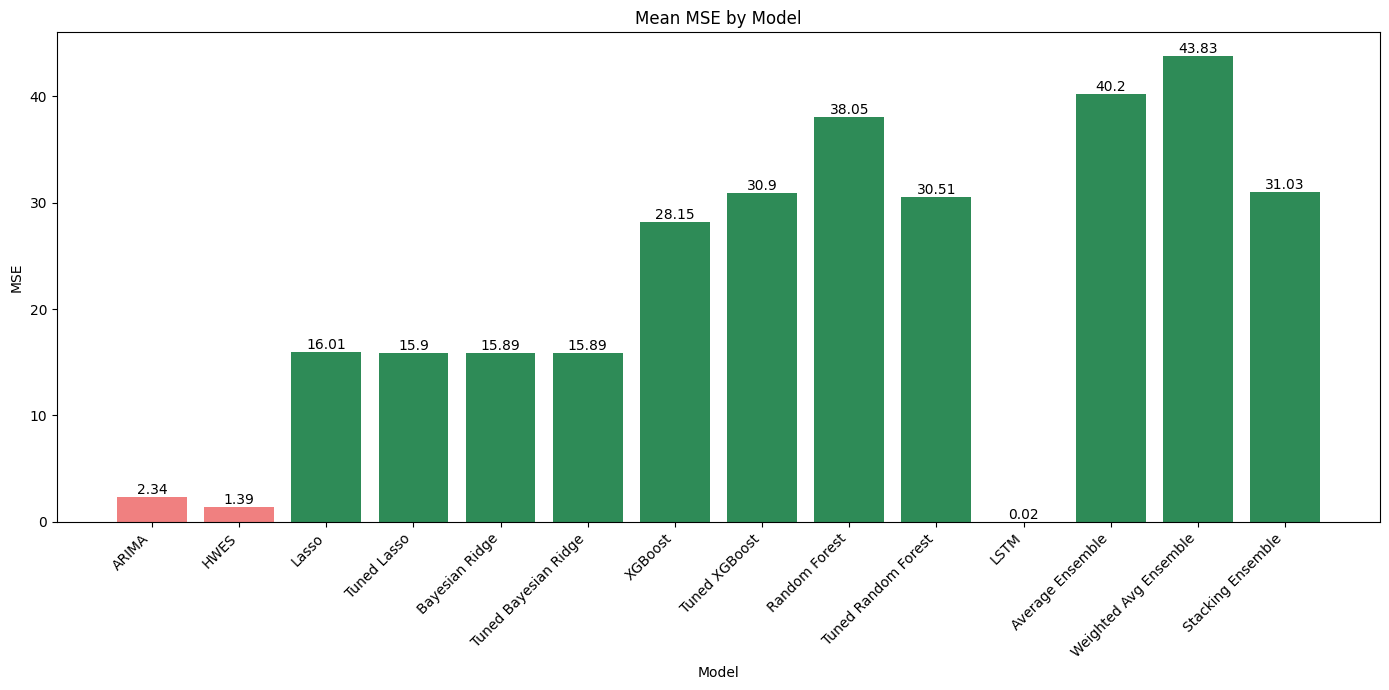

In [ ]:
# Evaluation Plot of all the models - By Model
comparison_df['MSE'] = pd.to_numeric(comparison_df['MSE'], errors='coerce')

## Set colors
colors = {
    'Time Series Model': 'lightcoral',
    'Linear Model': 'seagreen',
    'Tree Model': 'seagreen',
    'Deep Learning Model': 'darkorange',
    'Ensemble Model': 'seagreen'
}

comparison_df['Color'] = comparison_df['Category'].map(colors)

## Create the plot
plt.figure(figsize=(14, 7))
bars = plt.bar(comparison_df['Model'], comparison_df['MSE'], color=comparison_df['Color'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', ha='center')

plt.title('Mean MSE by Model')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## **Conclusion**

This project's journey through the realm of time-series forecasting has culminated in a set of valuable insights into weather prediction using machine learning. By carefully preprocessing the dataset and applying a variety of models, I could observe distinct patterns in predictive performance.





**Time Series models** like ARIMA and HWES excelled due to their affinity for temporal data, while Linear Models provided a solid baseline for performance. Tree Models, despite their sophistication, encountered difficulties with the complexity of weather data, often overfitting.

**The LSTM Deep Learning model** emerged as the top performer, showcasing its prowess in handling sequential data. Its impressive accuracy underscores the potential of neural networks in time-series analysis.

**Ensemble Techniques** integrated the strengths of individual models but yielded mixed results. The Stacking Ensemble, however, stood out for its robustness.

A comparative analysis, visualized through a bar plot, neatly encapsulated these findings, with the LSTM model showing remarkably low error metrics, highlighting the effectiveness of appropriately chosen models for time-series forecasting.

In summary, this project highlights the significance of matching the right models to the characteristics of time-series data, with the LSTM's superior performance offering a clear direction for future forecasting endeavors in similar datasets, it is chosen as the most suited model for the task.

## **References**

1. Chakraborty, R. et al., 2021. Study and prediction analysis of the employee turnover using machine learning approaches. In: 2021 IEEE 4th International Conference on Computing, Power and Communication Technologies (GUCON), pp. 1–6.

2. Chen, Y., He, K. and Tso, G.K., 2017. Forecasting crude oil prices: a deep learning based model. Procedia Computer Science, 122, pp.300-307.

3. Chen, Y., Yang, B., Dong, J. and Abraham, A., 2005. Time-series forecasting using flexible neural tree model. Information Sciences, 174(3-4), pp.219-235.

4. Garg, C. et al., 2022. Adaptive fuzzy logic models for the prediction of compressive strength of sustainable concrete. In: M. Bianchini, V. Piuri, S. Das and R.N. Shaw, eds. Advanced Computing and Intelligent Technologies. Lecture Notes in Networks and Systems, 218. Springer, Singapore.

5. Kumar, S., Mishra, S. and Singh, S.K., 2020. A machine learning-based model to estimate PM2.5 concentration levels in Delhi’s atmosphere. Heliyon, 6(11), e05618.

6. Sagheer, A. and Kotb, M., 2019. Time series forecasting of petroleum production using deep LSTM recurrent networks. Neurocomputing, 323, pp.203-213.

7. Shambulingappa, H., 2020. Crude oil price forecasting using machine learning. International Journal of Advanced Science and Innovation, 1(1).
Yao, T. and Zhang, Y.-J., 2017. Forecasting crude oil prices with the Google index. Energy Procedia, 105, pp.3772-3776.

8. Yao, T. and Zhang, Y.-J., 2017. Forecasting crude oil prices with the Google index. Energy Procedia, 105, pp.3772-3776.